## **Capstone MDS - DecisionTreeRegressor**

#### **_Integrantes:_**  

1. Evans Díaz   
1. Felipe Ojeda
1. Javier Cofre  
1. Luis Reinoso

In [186]:
# importar librerías
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm
import graphviz

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from scipy.stats import randint, uniform
from matplotlib.ticker import EngFormatter

In [187]:
# función cálculo R2, RMSE y MSE
def R2_RMSE(y_true, y_pred):
  # cálculo de R2 y RMSE
  r2 = r2_score(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  
  return print('R2:',r2), print('RMSE:',rmse), print('MSE:', mse)

## **_1. Lectura (carga) de los Datos_**

In [188]:
# importamos archivo
#df = pd.read_csv('../Data/df_final_pay_sin_mt.csv')

# importamos archivo desde github (ojo que la rama se llama master)
df = pd.read_csv('https://raw.githubusercontent.com/ecdiazl/capstone-project/master/Data/df_final_pay_sin_mt.csv')

In [189]:
# miramos el dataframe
df.head()

,year_2023,year_2024,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,CAT 798-AC,KOM-CHQ,KOM.960E5,Kom.930E-4,Kom.930E-4SE,Kom.930EN,Kom.930ER,Kom.930ER-MT,Kom.980E5,Komatsu AHS
0,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,96.0,395.0,96.0,240.0,0.0,132.0,24.0
1,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,96.0,396.0,96.0,240.0,0.0,132.0,24.0
2,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,96.0,394.0,96.0,240.0,0.0,132.0,24.0
3,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,95.0,396.0,96.0,240.0,0.0,132.0,24.0
4,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,96.0,395.0,96.0,240.0,0.0,132.0,24.0


In [190]:
# información general df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 84 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year_2023            1567 non-null   bool   
 1   year_2024            1567 non-null   bool   
 2   month_2              1567 non-null   bool   
 3   month_3              1567 non-null   bool   
 4   month_4              1567 non-null   bool   
 5   month_5              1567 non-null   bool   
 6   month_6              1567 non-null   bool   
 7   month_7              1567 non-null   bool   
 8   month_8              1567 non-null   bool   
 9   month_9              1567 non-null   bool   
 10  month_10             1567 non-null   bool   
 11  month_11             1567 non-null   bool   
 12  month_12             1567 non-null   bool   
 13  day_2                1567 non-null   bool   
 14  day_3                1567 non-null   bool   
 15  day_4                1567 non-null   b

## **_2 Preparación del DataFrame_**

In [191]:
# transformamos las variables bool a categorical y le asignamos 0 o 1
for col in df.columns:
  if df[col].dtype == 'bool':
     df[col] = df[col].astype('category').cat.codes
     df[col] = df[col].astype('category') # para que quede como category y no como int8

In [192]:
print('Nombre Columnas: ',df.columns)
print('Cantidad Columnas: ',len(df.columns))

Nombre Columnas:  Index(['year_2023', 'year_2024', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7',
       'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14',
       'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20', 'day_21',
       'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28',
       'day_29', 'day_30', 'day_31', 'shift_B', 'crew_E2', 'crew_E3',
       'crew_E4', 'total', 'efectivo', 'mantencion', 'mecanica', 'electrica',
       'mant_excl', 'mec_excl', 'elec_excl', 'som_excl', 'demora', 'r_prog',
       'r_noprg', 'waiting', 'queued', 'payload', 'distance', 'distance_down',
       'distance_down_level', 'distance_up', 'distance_up_level',
       'expected_time', 'lift_down', 'lift_down_level', 'lift_up',
       'lift_up_level', 'travel_time', 'CAT 797-F', 'CAT 798-AC', 'KOM-CHQ',
       'KOM.96

In [193]:
# cálculamos la desviaicón estándar y la media de payload
std_y = df['payload'].std()
mean_y = df['payload'].mean()

print('Desviación Estándar:',std_y)
print('Media:',mean_y)

Desviación Estándar: 19936.05577427206
Media: 142357.4639507874


In [194]:
# estandarizamos las variables numéricas
col_num = df.drop('payload', axis=1).select_dtypes(include=['float64','int64']).columns

scaler = StandardScaler()
df[col_num] = scaler.fit_transform(df[col_num])

## **_3 Modelo DecisionTreeRegressor_**

In [195]:
# definimos el tamaño del set de test
test_size = 0.3

In [196]:
# separamos los datos en X e y
X = df.drop('payload', axis=1)
y = df['payload']

# dividimos los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42) 

In [197]:
# Ajustar los hiperparámetros para prevenir el sobreajuste
model = DecisionTreeRegressor(max_depth=5, min_samples_split=20, min_samples_leaf=10)


In [198]:
# Entrenar el modelo
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, min_samples_split=20)

###   _3.1 Predicciones en el conjunto de entrenamiento_

In [199]:
# Realizar predicciones en el conjunto de entrenamiento
predictions_train = model.predict(X_train)

In [200]:
# resultados de R2, RMSE y MSE
R2_RMSE(y_train, predictions_train)

R2: 0.6837920727375847
RMSE: 11199.073410707502
MSE: 125419245.25841576


(None, None, None)

###  _3.2 Predicciones en el conjunto de testeo_

In [201]:
# Realizar predicciones en el conjunto de test
predictions_test = model.predict(X_test)

In [202]:
# resultados de R2, RMSE y MSE
R2_RMSE(y_test, predictions_test)

R2: 0.5413950161276944
RMSE: 13516.712946972164
MSE: 182701528.8908449


(None, None, None)

In [203]:
# Graficar el árbol de decisión
dot_data = export_graphviz(model, out_file=None, 
                            feature_names=X_train.columns,  
                            filled=True, rounded=True,  
                            special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render('../Graficos/payload_tree')

'../Graficos/payload_tree.pdf'

## **_4 Optimización del Modelo_**

### _4.1 Selección de Variables (LassoCV)_

In [204]:
# buscamos alpha optimo con LassoCV
alpha_values = np.linspace(0.01, 300, 3000)

# Crea un objeto LassoCV
lasso_cv = LassoCV(alphas=alpha_values, cv=5)

# Ajusta el modelo a los datos de entrenamiento
lasso_cv.fit(X_train, y_train)

# Valor óptimo de alpha
best_alpha = lasso_cv.alpha_

# Evalúa el modelo en el conjunto de prueba
score = lasso_cv.score(X_test, y_test)

print(f"Mejor valor de alpha: {best_alpha}")
print(f"Puntuación en el conjunto de prueba: {score}")

/opt/homebrew/Caskroom/miniconda/base/envs/py312/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42258714.71920776, tolerance: 35584840.128719084
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/Caskroom/miniconda/base/envs/py312/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120978834.77467346, tolerance: 35584840.128719084
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/Caskroom/miniconda/base/envs/py312/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 232749727.64689636, tolerance: 35584840.128719084
  model = cd_fast.enet_coordinat

Mejor valor de alpha: 51.02530510170057
Puntuación en el conjunto de prueba: 0.7151309355390548


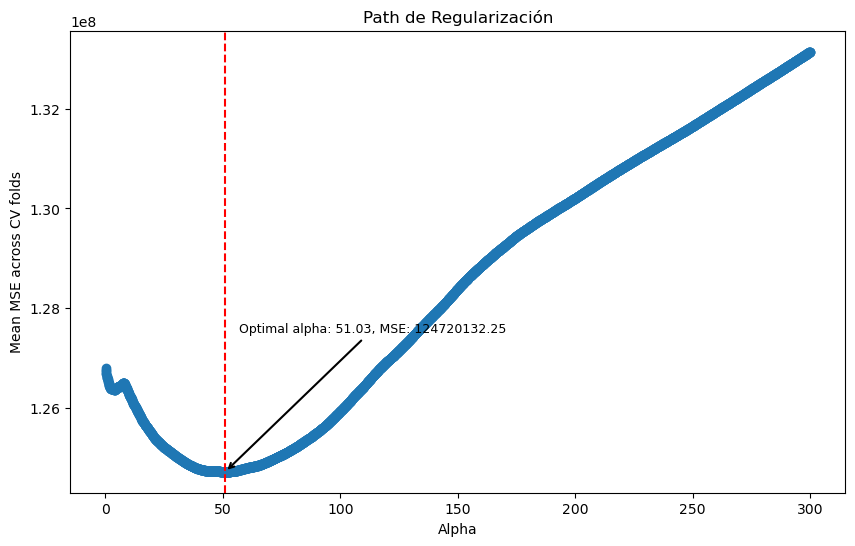

In [205]:
# Graficar MSE vs. Alpha
plt.figure(figsize=(10,6))
plt.plot(lasso_cv.alphas_, np.mean(lasso_cv.mse_path_, axis=1), '-o')
plt.xlabel('Alpha')
plt.ylabel('Mean MSE across CV folds')
plt.title('Path de Regularización')
plt.axvline(lasso_cv.alpha_, color='red', linestyle='--')

# Anotar el valor óptimo de alpha en el gráfico
plt.annotate(f'Optimal alpha: {lasso_cv.alpha_:.2f}, MSE: {np.min(np.mean(lasso_cv.mse_path_, axis=1)):.2f}',
             xy=(lasso_cv.alpha_, np.min(np.mean(lasso_cv.mse_path_, axis=1))),
             xycoords='data', xytext=(10,100), 
             textcoords='offset points',
             arrowprops=dict(arrowstyle="->", lw=1.5),
             fontsize=9)

plt.show()

In [206]:
# Aplicar Lasso para la selección de características
lasso = Lasso(alpha=lasso_cv.alpha_)  
lasso.fit(X_train, y_train)

# Seleccionar las características que tienen coeficientes no nulos
selected_features = X_train.columns[lasso.coef_ != 0]

print("Características seleccionadas:")
print(selected_features)


Características seleccionadas:
Index(['year_2024', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'day_2', 'day_3', 'day_4', 'day_5',
       'day_6', 'day_11', 'day_13', 'day_17', 'day_19', 'day_20', 'day_22',
       'day_23', 'day_26', 'day_27', 'day_28', 'day_30', 'day_31', 'shift_B',
       'crew_E2', 'crew_E4', 'efectivo', 'mantencion', 'mecanica', 'mant_excl',
       'mec_excl', 'demora', 'r_prog', 'r_noprg', 'waiting', 'queued',
       'distance_down_level', 'distance_up', 'distance_up_level',
       'expected_time', 'lift_down', 'lift_down_level', 'lift_up',
       'travel_time', 'CAT 797-F', 'CAT 798-AC', 'KOM-CHQ', 'Kom.930E-4',
       'Kom.930E-4SE', 'Kom.930EN', 'Kom.930ER-MT', 'Komatsu AHS'],
      dtype='object')


In [207]:
len(selected_features)

55

> Volvemos ajustar el modelo con las variables seleccionadas

In [208]:
# separamos los datos en train y test
X_lasso= df[selected_features]
y_lasso = df['payload']

# dividimos los datos en train y test
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X_lasso, y_lasso, test_size=test_size, random_state=42)

In [209]:
# Inicializar el regresor DecisionTree
model_lasso = DecisionTreeRegressor(max_depth=5, min_samples_split=20, min_samples_leaf=10)

In [210]:
# Entrenar el modelo DecisionTree
model_lasso.fit(X_train_lasso, y_train_lasso)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, min_samples_split=20)

#### 4.1.1 Predicciones en el conjunto de entrenamiento

In [211]:
# Realizar predicciones con el modelo entrenado
predictions_lasso_train = model_lasso.predict(X_train_lasso)

In [212]:
# resultado de R2, RMSE y MSE
R2_RMSE(y_train_lasso, predictions_lasso_train)

R2: 0.6821851710526762
RMSE: 11227.493009914506
MSE: 126056599.28767908


(None, None, None)

#### 4.1.2 Predicciones en el conjunto de testeo

In [213]:
# Realizar predicciones con el modelo entrenado
predictions_lasso_test = model_lasso.predict(X_test_lasso)

In [214]:
# resultado de R2, RMSE y MSE
R2_RMSE(y_test_lasso, predictions_lasso_test)

R2: 0.5497636722397914
RMSE: 13392.818168606096
MSE: 179367578.49734557


(None, None, None)

In [215]:
# Graficar el árbol de decisión
dot_data_lasso= export_graphviz(model_lasso, out_file=None, 
                            feature_names=X_train_lasso.columns,  
                            filled=True, rounded=True,  
                            special_characters=True,
                            proportion=True
                            ) 
# Modifica el archivo DOT para tener una orientación vertical
dot_data_lasso = dot_data_lasso.replace('digraph Tree {', 'digraph Tree {\nrankdir=LR;')

graph = graphviz.Source(dot_data_lasso)  
graph.render("../Graficos/payload_tree_lasso")

'../Graficos/payload_tree_lasso.pdf'

In [216]:
model_lasso.tree_.node_count

55

### _4.2 Poda Arbol (LassoCV)_

In [217]:
# Calcular el error cuadrático medio en el conjunto de prueba
y_pred_lasso = model_lasso.predict(X_test_lasso)
mse_lasso = mean_squared_error(y_test_lasso, y_pred_lasso)
print(f"Error cuadrático medio sin poda: {mse_lasso}")

# Podar el árbol
path = model_lasso.cost_complexity_pruning_path(X_train_lasso, y_train_lasso)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

model_lassos = []
for ccp_alpha in ccp_alphas:
    model_lasso = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha)
    model_lasso.fit(X_train_lasso, y_train_lasso)
    model_lassos.append(model_lasso)

# Eliminar el último regresor, ya que corresponde al árbol no podado
model_lassos = model_lassos[:-1]
ccp_alphas = ccp_alphas[:-1]

# Evaluar el error cuadrático medio de cada árbol podado en el conjunto de prueba
mses = [mean_squared_error(y_test_lasso, model_lasso.predict(X_test_lasso)) for model_lasso in model_lassos]

# Encontrar el índice del mejor árbol (el que tiene el menor error cuadrático medio)
best_index = mses.index(min(mses))
best_model_lasso = model_lassos[best_index]
best_ccp_alpha = ccp_alphas[best_index]

# Calcular y mostrar el error cuadrático medio del mejor árbol podado
y_pred_pruned = best_model_lasso.predict(X_test_lasso)
mse_pruned = mean_squared_error(y_test_lasso, y_pred_pruned)
print(f"Error cuadrático medio con poda: {mse_pruned}")

Error cuadrático medio sin poda: 179367578.49734557
Error cuadrático medio con poda: 168877762.8254098


In [218]:
best_model_lasso.tree_.node_count

25

In [219]:
# Graficar el árbol de decisión
dot_data_lasso_pruned= export_graphviz(best_model_lasso, out_file=None, 
                            feature_names=X_train_lasso.columns,  
                            filled=True, rounded=True,  
                            special_characters=True,
                            proportion=True
                            )
# Modifica el archivo DOT para tener una orientación vertical
dot_data_lasso_pruned = dot_data_lasso_pruned.replace('digraph Tree {', 'digraph Tree {\nrankdir=LR;')

graph = graphviz.Source(dot_data_lasso_pruned)  
graph.render("../Graficos/payload_tree_lasso_pruned")

'../Graficos/payload_tree_lasso_pruned.pdf'

#### _4.2.1 Predicciones en el conjunto de entrenamiento_

In [220]:
# Realizar predicciones con el modelo entrenado
predictions_lasso_train_pruned = best_model_lasso.predict(X_train_lasso)

In [221]:
# resultado de R2, RMSE y MSE
R2_RMSE(y_train_lasso, predictions_lasso_train_pruned)

R2: 0.623842884480245
RMSE: 12214.631110325108
MSE: 149197213.161322


(None, None, None)

In [222]:
feature_names = X_train_lasso.columns.tolist() + [y_train_lasso.name]

In [223]:
feature_names

['year_2024',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'day_2',
 'day_3',
 'day_4',
 'day_5',
 'day_6',
 'day_11',
 'day_13',
 'day_17',
 'day_19',
 'day_20',
 'day_22',
 'day_23',
 'day_26',
 'day_27',
 'day_28',
 'day_30',
 'day_31',
 'shift_B',
 'crew_E2',
 'crew_E4',
 'efectivo',
 'mantencion',
 'mecanica',
 'mant_excl',
 'mec_excl',
 'demora',
 'r_prog',
 'r_noprg',
 'waiting',
 'queued',
 'distance_down_level',
 'distance_up',
 'distance_up_level',
 'expected_time',
 'lift_down',
 'lift_down_level',
 'lift_up',
 'travel_time',
 'CAT 797-F',
 'CAT 798-AC',
 'KOM-CHQ',
 'Kom.930E-4',
 'Kom.930E-4SE',
 'Kom.930EN',
 'Kom.930ER-MT',
 'Komatsu AHS',
 'payload']

In [224]:
# Obtener importancias
importances = best_model_lasso.feature_importances_

# Crear DataFrame para mostrar resultados
feature_names = best_model_lasso.feature_names_in_
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importances_df)

                Feature  Importance
41    distance_up_level    0.635826
29             efectivo    0.080948
47            CAT 797-F    0.067591
54          Komatsu AHS    0.058082
37              waiting    0.053239
38               queued    0.037791
31             mecanica    0.036443
51         Kom.930E-4SE    0.015566
1               month_3    0.014513
46          travel_time    0.000000
36              r_noprg    0.000000
53         Kom.930ER-MT    0.000000
30           mantencion    0.000000
49              KOM-CHQ    0.000000
32            mant_excl    0.000000
33             mec_excl    0.000000
34               demora    0.000000
35               r_prog    0.000000
48           CAT 798-AC    0.000000
45              lift_up    0.000000
52            Kom.930EN    0.000000
50           Kom.930E-4    0.000000
40          distance_up    0.000000
28              crew_E4    0.000000
42        expected_time    0.000000
43            lift_down    0.000000
44      lift_down_level    0

In [225]:
# seleccionamos las variables más importantes
selected_features_pruned = importances_df[importances_df['Importance'] > 0]
selected_features_pruned

,Feature,Importance
41,distance_up_level,0.635826
29,efectivo,0.080948
47,CAT 797-F,0.067591
54,Komatsu AHS,0.058082
37,waiting,0.053239
38,queued,0.037791
31,mecanica,0.036443
51,Kom.930E-4SE,0.015566
1,month_3,0.014513


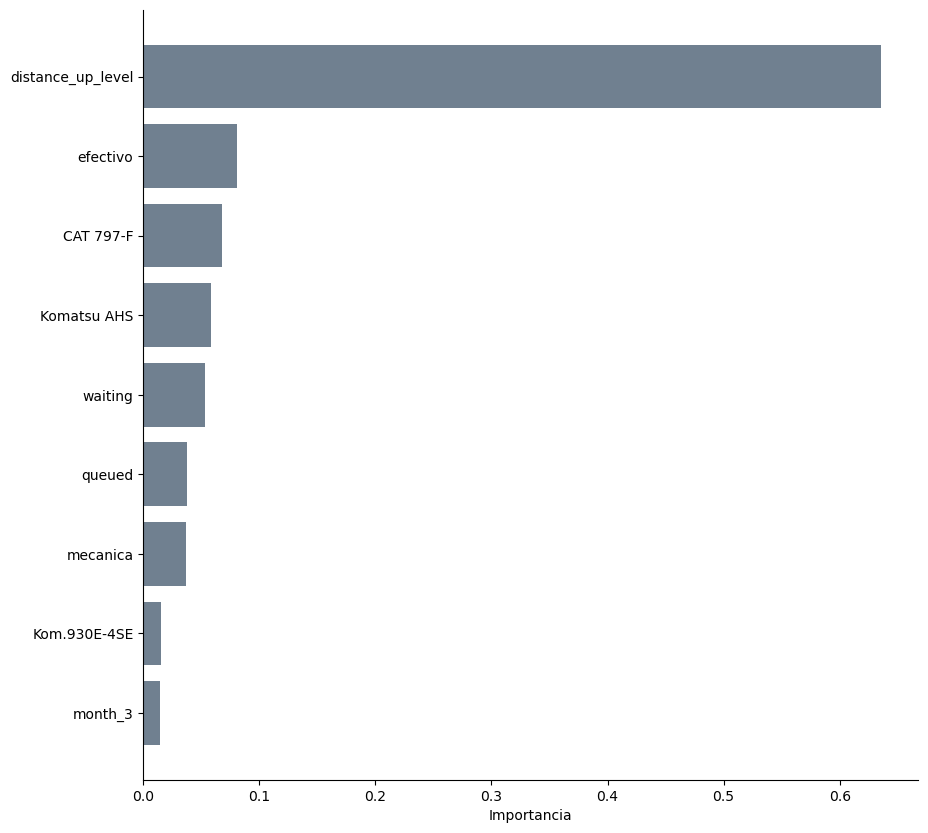

In [226]:
# Graficar importancias
plt.figure(figsize=(10, 10))
plt.barh(selected_features_pruned['Feature'], selected_features_pruned['Importance'], color='slategray')
plt.xlabel('Importancia')
plt.gca().invert_yaxis()
sns.despine()
plt.show()

#### _4.2.2 Predicciones en el conjunto de testeo_

In [227]:
# Realizar predicciones con el modelo entrenado
predictions_lasso_test_pruned = best_model_lasso.predict(X_test_lasso)

In [228]:
# resultado de R2, RMSE y MSE
R2_RMSE(y_test_lasso, predictions_lasso_test_pruned)

R2: 0.576094495940373
RMSE: 12995.297719768094
MSE: 168877762.8254098


(None, None, None)

## _**5 Modelo DecisionTreeRegressor Optimizado**_

### _5.1 Hiperparámetros_

In [229]:
# Definir los hiperparámetros para la búsqueda
param_dist_tree = {
    'max_depth': randint(1, 200),
    'min_samples_split': randint(2, 200),
    'min_samples_leaf': randint(1, 200),
    'max_features':  [None, 'sqrt', 'log2'],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'min_impurity_decrease': uniform(0,1)
}

# Crear la búsqueda de hiperparámetros para DecisionTreeRegressor
random_search_tree = RandomizedSearchCV(
    estimator=DecisionTreeRegressor(),
    param_distributions=param_dist_tree,
    n_iter=10000,
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

# Ajustar el modelo
random_search_tree.fit(X_train_lasso, y_train_lasso)

# Mejor combinación de hiperparámetros para el árbol de decisión
best_params_tree = random_search_tree.best_params_
print("Best parameters for DecisionTreeRegressor: ", best_params_tree)


Best parameters for DecisionTreeRegressor:  {'criterion': 'poisson', 'max_depth': 79, 'max_features': None, 'min_impurity_decrease': 0.37814133734377986, 'min_samples_leaf': 7, 'min_samples_split': 72}


/opt/homebrew/Caskroom/miniconda/base/envs/py312/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [230]:
# Crear el DecisionTreeRegressor con los mejores parámetros encontrados
best_tree = DecisionTreeRegressor(**best_params_tree)

In [231]:
# Entrenar el modelo DecisionTreeRegressor con los mejores hiperparámetros
best_tree.fit(X_train_lasso, y_train_lasso)

DecisionTreeRegressor(criterion='poisson', max_depth=79,
                      min_impurity_decrease=0.37814133734377986,
                      min_samples_leaf=7, min_samples_split=72)

#### _5.1.1 Predicciones en el conjunto de entrenamiento_

In [232]:
# Realizar predicciones en el conjunto de entrenamiento
predictions_lasso_hiper_train = best_tree.predict(X_train_lasso)

# Realizar predicciones en el conjunto de prueba
predictions_lasso_hiper_test = best_tree.predict(X_test_lasso)

In [233]:
# resultados de R2, RMSE y MSE
R2_RMSE(y_train_lasso, predictions_lasso_hiper_train)

R2: 0.683552455329999
RMSE: 11203.315848233624
MSE: 125514285.99528266


(None, None, None)

#### _5.1.2 Predicciones en el conjunto de testeo_

In [234]:
# resultados de R2, RMSE y MSE
R2_RMSE(y_test_lasso, predictions_lasso_hiper_test)

R2: 0.5824981411215835
RMSE: 12896.768746205858
MSE: 166326644.09311223


(None, None, None)

In [235]:
# Graficar el árbol de decisión
dot_data_best = export_graphviz(best_tree, out_file=None, 
                            feature_names=X_train_lasso.columns,  
                            filled=True, rounded=True,  
                            special_characters=True)  
graph = graphviz.Source(dot_data_best)  
graph.render("../Graficos/payload_tree_best")

'../Graficos/payload_tree_best.pdf'

In [236]:
results_df = pd.DataFrame(random_search_tree.cv_results_)
results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_impurity_decrease,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.176962,0.023384,0.011348,0.018368,absolute_error,180,None,0.183435,72,190,"{'criterion': 'absolute_error', 'max_depth': 1...",0.422982,0.487648,0.432433,0.428357,0.525175,0.459319,0.040352,2863
1,0.040780,0.018656,0.001769,0.000019,squared_error,103,sqrt,0.155995,75,89,"{'criterion': 'squared_error', 'max_depth': 10...",0.370407,0.434659,0.394314,0.361972,0.418681,0.396007,0.027658,5439
2,0.056123,0.040800,0.002229,0.000947,squared_error,100,log2,0.020584,2,89,"{'criterion': 'squared_error', 'max_depth': 10...",0.417973,0.486178,0.387432,0.405588,0.434976,0.426429,0.033674,4059
3,0.059500,0.034051,0.002592,0.001536,poisson,158,sqrt,0.000779,188,22,"{'criterion': 'poisson', 'max_depth': 158, 'ma...",0.349668,0.311493,0.285887,0.217727,0.441218,0.321199,0.073841,7956
4,0.068133,0.047537,0.002364,0.001148,squared_error,58,sqrt,0.007066,89,50,"{'criterion': 'squared_error', 'max_depth': 58...",0.457046,0.283552,0.337432,0.457181,0.292100,0.365462,0.077041,6487


In [237]:
results_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_criterion', 'param_max_depth', 'param_max_features',
       'param_min_impurity_decrease', 'param_min_samples_leaf',
       'param_min_samples_split', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

/var/folders/82/981937551rd3qhsg1c05yn4c0000gn/T/ipykernel_2001/3173258646.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=results_df, x='param_max_depth', y='mean_test_score',  palette='viridis')
/var/folders/82/981937551rd3qhsg1c05yn4c0000gn/T/ipykernel_2001/3173258646.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Número de Estimadores')


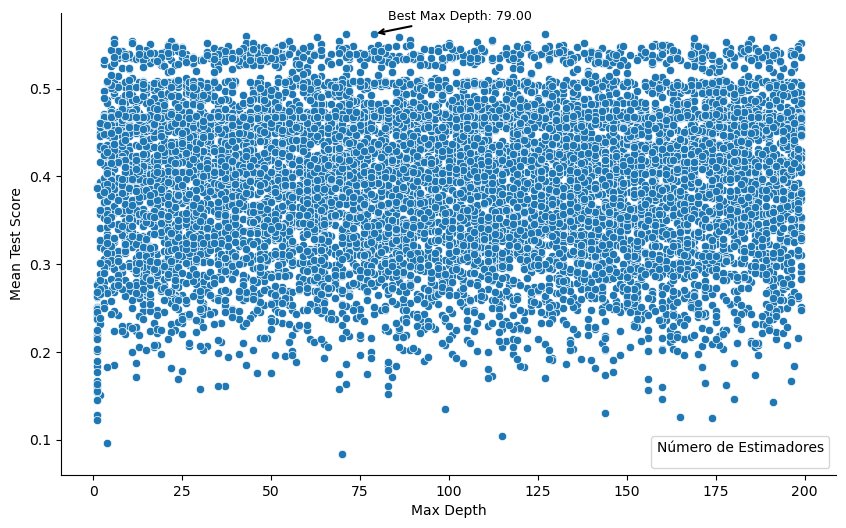

In [238]:
# graficar la relación entre el RMSE y los valores de los hiperparámetros
plt.figure(figsize=(10,6))
sns.scatterplot(data=results_df, x='param_max_depth', y='mean_test_score',  palette='viridis')

# mejoramos la visualización
#plt.title('Mean Test Score vs. Learning Rate')
plt.xlabel('Max Depth')
plt.ylabel('Mean Test Score')
plt.legend(title='Número de Estimadores')
sns.despine()

# anotamos el mejor valor de learning rate
plt.annotate(f'Best Max Depth: {best_params_tree["max_depth"]:.2f}',
             xy=(best_params_tree['max_depth'], random_search_tree.best_score_),
             xycoords='data', xytext=(10,10), 
             textcoords='offset points',
             arrowprops=dict(arrowstyle="->", lw=1.5),
             fontsize=9)
plt.show()

### _5.2 Poda Árbol Hiper parametrizado_

In [239]:
# Calcular el error cuadrático medio en el conjunto de prueba
y_pred_best_tree = best_tree.predict(X_test_lasso)
mse_best_tree = mean_squared_error(y_test_lasso, y_pred_best_tree)
print(f"Error cuadrático medio sin poda: {mse_best_tree}")

# Podar el árbol
path = best_tree.cost_complexity_pruning_path(X_train_lasso, y_train_lasso)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

model_best_trees = []
for ccp_alpha in ccp_alphas:
    best_tree = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha)
    best_tree.fit(X_train_lasso, y_train_lasso)
    model_best_trees.append(best_tree)

# Eliminar el último regresor, ya que corresponde al árbol no podado
model_best_trees = model_best_trees[:-1]
ccp_alphas = ccp_alphas[:-1]

# Evaluar el error cuadrático medio de cada árbol podado en el conjunto de prueba
mses = [mean_squared_error(y_test_lasso, best_tree.predict(X_test_lasso)) for best_tree in model_best_trees]

# Encontrar el índice del mejor árbol (el que tiene el menor error cuadrático medio)
best_index = mses.index(min(mses))
best_model_tree = model_best_trees[best_index]
best_ccp_alpha = ccp_alphas[best_index]

# Calcular y mostrar el error cuadrático medio del mejor árbol podado
y_pred_pruned = best_model_tree.predict(X_test_lasso)
mse_pruned = mean_squared_error(y_test_lasso, y_pred_pruned)
print(f"Error cuadrático medio con poda: {mse_pruned}")

Error cuadrático medio sin poda: 166326644.09311223
Error cuadrático medio con poda: 245454683.5404429


In [240]:
# Graficar el árbol de decisión
dot_data_best_pruned = export_graphviz(best_model_tree, out_file=None, 
                            feature_names=X_train_lasso.columns,  
                            filled=True, rounded=True,  
                            special_characters=True)  
graph = graphviz.Source(dot_data_best_pruned)  
graph.render("../Graficos/payload_tree_best_pruned")

'../Graficos/payload_tree_best_pruned.pdf'

#### _5.2.1 Predicciones en el conjunto de entrenamiento_

In [241]:
# Realizar predicciones en el conjunto de entrenamiento
predictions_best_train_pruned = best_model_tree.predict(X_train_lasso)

In [242]:
# resultado de R2, RMSE y MSE
R2_RMSE(y_train_lasso, predictions_best_train_pruned)

R2: 0.9999960827381302
RMSE: 39.41731312921456
MSE: 1553.7245743265507


(None, None, None)

#### _5.2.2 Predicciones en el conjunto de testeo_

In [243]:
# Realizar predicciones en el conjunto de test
predictions_best_test_pruned = best_model_tree.predict(X_test_lasso)

In [244]:
# resultado de R2, RMSE y MSE
R2_RMSE(y_test_lasso, predictions_best_test_pruned)

R2: 0.3838763043209138
RMSE: 15666.993442918234
MSE: 245454683.5404429


(None, None, None)